In [191]:
# See http://www.wikimedecine.fr/Electrocardiogramme_(ECG)_-_%C3%A9l%C3%A9ments_d%27interpr%C3%A9tation

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import datetime, time
from funs import *

import wfdb

In [195]:
from dsfaker.generators import *
from dsfaker.listeners import *
from queue import Queue


# Pan Tompkins real-time QRS detector
#   Steps: ECG -> Filters -> Derivation -> Squaring function -> Integration -> Adjusting thresholds -> Decision -> Result

sig, fields = wfdb.rdsamp('mimic3wdb/matched/s00079/3887555_0020', pbdl=1, dldir='data/mimic3wdb-200315/s00079')

RR_LOW  =  170 # ms -> Lowest  interval between two Rpeaks (352bpm)
RR_MEAN = 600 # ms
RR_HIGH = 2000 # ms -> Highest interval between two Rpeaks ( 30bpm)
RR_MISSED  = 3000 # ms -> Interval for which we consider that we missed a Rpeak (20bpm)

INIT_THRESH_I = 0.3 # MWI minimum value
INIT_THRESH_F = 0.4 # Filtered minimum value

MAX_MISS = 5
L_MUL = 0.92
H_MUL = 1.16
M_MUL = 1.66

class QRSDetector(Generator):
    def __init__(self, data_gen, size, fs):
        self.listeners = {
            'orig': CircularBuffer(size),
            'lp': CircularBuffer(size),
            'hp': CircularBuffer(size),
            'diff': CircularBuffer(size),
            'sq': CircularBuffer(size),
            'mwi': CircularBuffer(size)
        }
        self.data_gen = data_gen
        self.fs = fs
        
        # Band-pass filter
        self.lp = DifferenceEquation(self.data_gen, "2*y(t-1) - y(t-2) + x(t) - 2*x(t-6) + x(t-12)")
        self.hp = DifferenceEquation(self.lp, "y(t-1) - x(t)/32 + x(t-16) - x(t-17) + x(t-32)/32")
        
        # Derivation
        self.deriv = DifferenceEquation(self.hp, "(2*x(t) + x(t-1) - x(t-3) - 2*x(t-4))/8.0")
        
        # Squaring
        self.sq = self.deriv ** 2

        # Moving Window Integration
        mwi_width = 80 # ms
        mwi_size = int((mwi_width/1000)*self.fs)
        self.mwi = MeanHistory(MeanHistory(self.sq, mwi_size), 4) # Add a MeanHistory(4) to smooth the result (remove noise)
        
        self.data_gen.add_listener(self.listeners['orig'])
        self.lp.add_listener(self.listeners['lp'])
        self.hp.add_listener(self.listeners['hp'])
        self.deriv.add_listener(self.listeners['diff'])
        self.sq.add_listener(self.listeners['sq'])
        self.mwi.add_listener(self.listeners['mwi'])
        
        self.lp.delay = 5
        self.hp.delay = 16
        self.deriv.delay = 2
        self.mwi.delay = 2
        
        self.delay = self.lp.delay + self.hp.delay + self.deriv.delay + self.mwi.delay + 8
        
        # Algorithm variables
        self.c = 0 # Count of valid peaks
        self.interval = 1000 # Since last QRS
        self.miss = 0
        
        # Historical peak values        
        self.hist_correct_peak_val = None
        self.noise_peaks_since_last_R = []
        
        # Historical RR intervals
        self.hist_RR_1 = CircularBuffer(8)
        self.hist_RR_2 = CircularBuffer(8)
        
        # QRS variables
        self.THRESH_I = INIT_THRESH_I # Threshold for MWI signal
        self.THRESH_F = INIT_THRESH_F # Threshold for filtered signal
        self.RR_LOW = RR_LOW
        self.RR_HIGH = RR_HIGH
        self.RR_MISSED = RR_MISSED
        self.SPK_I = None
        self.SPK_F = None
        self.NPK_I = None
        self.NPK_F = None
        self.current_hr = numpy.nan
        
    def _get_single(self):        
        self.mwi.get_single()
        peakF = self.listeners['hp'].get_prev(-self.deriv.delay-self.mwi.delay-1)
        
        is_peak, peakI = self._is_peak('mwi')
        
        RR = self.interval * (1.0 / self.fs) * 1000 # milliseconds since last Rpeak
        
        mwi_is_qrs = is_peak and peakI >= self.THRESH_I
        fil_is_qrs = is_peak and peakF >= self.THRESH_F
        is_qrs = mwi_is_qrs# and fil_is_qrs
        
        noise_peak = False
        if is_qrs and RR_LOW <= RR and RR <= RR_HIGH or is_qrs and self.c <= 2:
            self.interval = 0
            self.noise_peaks_since_last_R = []
            self.miss = 0
        elif is_peak:
            # It is a noise peak!
            noise_peak = True
            self.noise_peaks_since_last_R.append((self.interval, peakI, peakF))
         
        # If we didn't found a valid Rpeak and the last Rpeak is too old
        found_missing = False
        if not is_qrs and RR >= self.RR_MISSED:
            # We missed a peak, let's scrool back in time
            self.miss += 1
            nb_peaks = len(self.noise_peaks_since_last_R)
            if nb_peaks > 0:
                j, (ix, vmwix, vfilx) = max(enumerate(self.noise_peaks_since_last_R), key=lambda x: x[1][1])
                if vmwix >= 0.5 * self.THRESH_I and vfilx >= 0.5 * self.THRESH_F:
                    self.noise_peaks_since_last_R = self.noise_peaks_since_last_R[j+1:] if j+1 < nb_peaks else []
                    found_missing = True
                    self.interval -= ix
                    RR = self.interval * (1.0 / self.fs) * 1000
                    print('Missed: c={} | RR={}'.format(self.c, RR))
        
        if is_qrs or found_missing:
            self.c += 1
            if self.c == 1:
                self.hist_correct_peak_val = CircularBuffer(10, numpy.full(10, peakI))
            if self.c >= 2:
                if self.RR_LOW <= RR and RR <= self.RR_HIGH:
                    self.hist_RR_2.put_single(RR)
                self.hist_RR_1.put_single(RR)
                if RR_LOW <= RR and RR <= RR_HIGH:
                    self.current_hr = 60000.0 / RR
                else:
                    self.current_hr = 0
        
        # Update thresholds
        if is_peak:
            if noise_peak:
                if self.NPK_I is None:
                    self.NPK_I = peakI
                    self.NPK_F = peakF
                else:
                    self.NPK_I = 0.125 * peakI + 0.875 * self.NPK_I
                    self.NPK_F = 0.125 * peakF + 0.875 * self.NPK_F
            else:
                if self.SPK_I is None:
                    self.SPK_I = peakI
                    self.SPK_F = peakF
                else:
                    self.SPK_I = 0.125 * peakI + 0.875 * self.SPK_I
                    self.SPK_F = 0.125 * peakF + 0.875 * self.SPK_F
        if found_missing:
            self.hist_correct_peak_val.put_single(vmwix)
            if self.SPK_I is None:
                self.SPK_I = vmwix
                self.SPK_F = vfilx
            else:
                self.SPK_I = 0.25 * vmwix + 0.75 * self.SPK_I
                self.SPK_F = 0.25 * vfilx + 0.75 * self.SPK_F
        
        regular_hr = self._is_regular()
        
        if is_qrs:
            self.hist_correct_peak_val.put_single(peakI)
            if self.SPK_I is None:
                self.SPK_I = peakI
                self.SPK_F = peakF
            if self.NPK_I is None:
                self.THRESH_I = 0.5 * self.SPK_I
                self.THRESH_F = 0.5 * self.SPK_F
            else:
                self.THRESH_I = self.NPK_I + 0.25 * (self.SPK_I - self.NPK_I)
                self.THRESH_F = self.NPK_F + 0.25 * (self.SPK_F - self.NPK_F)

            if not regular_hr:
                self.THRESH_I *= 0.5
                self.THRESH_F *= 0.5
        
            self.RR_LOW = 0.92 * self.hist_RR_2.get_mean()
            self.RR_HIGH = 1.16 * self.hist_RR_2.get_mean()
            self.RR_MISSED = 1.66 * self.hist_RR_2.get_mean()        
        
        self.interval += 1
            
        return self.current_hr, self.c, 1 if is_peak else numpy.nan, 1 if is_qrs else numpy.nan, peakI, peakF, RR, self.RR_LOW, self.RR_HIGH, self.RR_MISSED, self.THRESH_I, self.THRESH_F
    
    def _is_regular(self):
        for v in self.hist_RR_1.get_all():
            if v < RR_LOW or RR_HIGH < v:
                return False
        return True
    
    def _is_peak(self, signame):
        s = self.listeners[signame]
        vl3 = s.get_prev(-5)
        vl2 = s.get_prev(-4)
        vl1 = s.get_prev(-3)
        v0 = s.get_prev(-2)
        vp1 = s.get_prev(-1)
        t = vl3 < vl2 and vl2 < vl1 and vl1 < v0 and v0 >= vp1
        if t and self.c >= 10:
            tmp = self.hist_correct_peak_val.get_mean()
            t = tmp * 0.5 <= v0 and v0 <= tmp * 1.5
        return t, v0
        
print(fields)
sig_name = "II"
idx_sig = fields['signame'].index(sig_name)

print('Index for signame {} is {}. It contains {} samples.'.format(sig_name, idx_sig, sig.shape[0]))
size = 1000 #sig.shape[0]
fs = fields['fs']

sig1 = sig[None:None, idx_sig]
qrs = QRSDetector(RepeatPattern(sig1[:size]), size, fs)

orig_x = []
orig_y = []
hrs_x = []
hrs_y = []
cc = []
qrs_x = []
qrs_y = []
pi = []
pf = []
ti = []
tf = []
rr = []
rrl = []
rrh = []
rrm = []
delay = qrs.delay
for k in range(size - delay):
    hr, c, is_peak, is_qrs, peakI, peakF, RR, RRlow, RRhigh, RRmissed, tI, tF = qrs.get_single()
    orig_x.append(k)
    orig_y.append(qrs.listeners['orig'].get_prev(-1))
    cc.append(c)
    if not numpy.isnan(hr):
        hrs_x.append(k-delay)
        hrs_y.append(hr)
    if is_qrs == 1:
        qrs_x.append(k-delay)
        qrs_y.append(orig_y[-delay])
    #ips.append(is_qrs)
    pi.append(peakI)
    pf.append(peakF)
    ti.append(tI)
    tf.append(tF)
    rr.append(RR)
    rrl.append(RRlow)
    rrh.append(RRhigh)
    rrm.append(RRmissed)
#     print(c, hr, is_qrs, peakI, peakF, RR, RRlow, RRhigh, RRmissed, tI, tF)
orig = qrs.listeners['orig'].get_all()
print(max(cc))

Downloaded all missing files for record.
{'nseg': 1, 'nsig': 4, 'fs': 125.0, 'nsamp': 885000, 'basetime': '13:07:34.800', 'basedate': '', 'filename': ['3887555_0020.dat', '3887555_0020.dat', '3887555_0020.dat', '3887555_0020.dat'], 'fmt': ['80', '80', '80', '80'], 'sampsperframe': [1, 1, 1, 1], 'skew': [0, 0, 0, 0], 'byteoffset': [0, 0, 0, 0], 'gain': [73.0, 53.0, 1.25, 5.0], 'units': ['mV', 'mV', 'mmHg', 'mmHg'], 'baseline': [0, 0, -100, -100], 'initvalue': [-1, 2, 3, 30], 'signame': ['II', 'MCL1', 'ABP', 'PAP'], 'nsampseg': [], 'comments': []}
Index for signame II is 0. It contains 885000 samples.
9


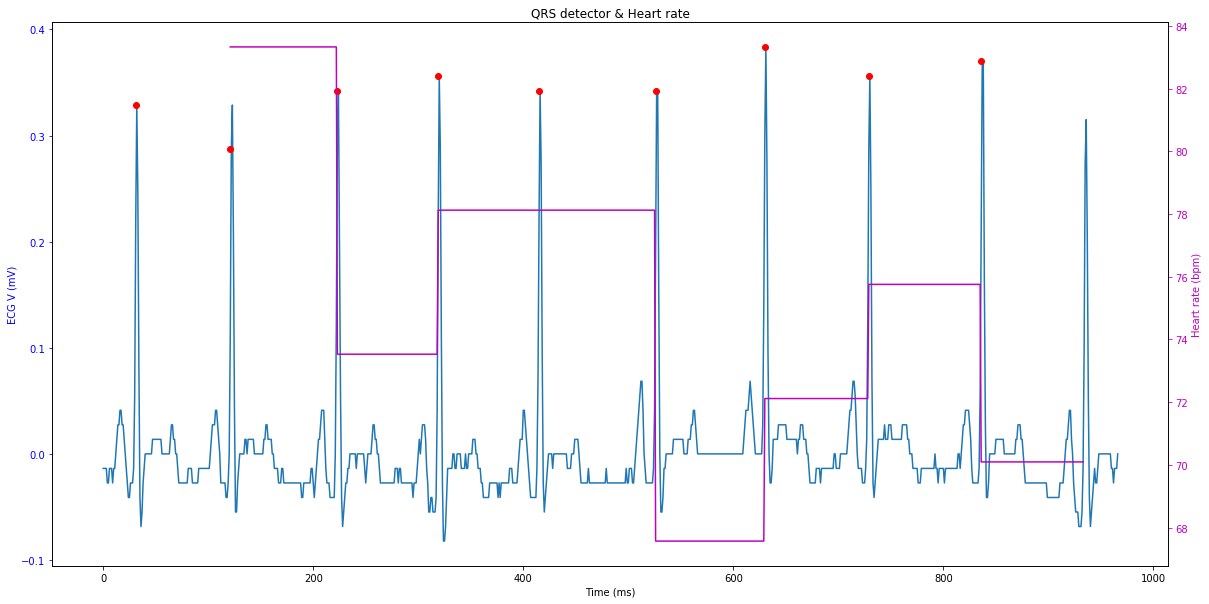

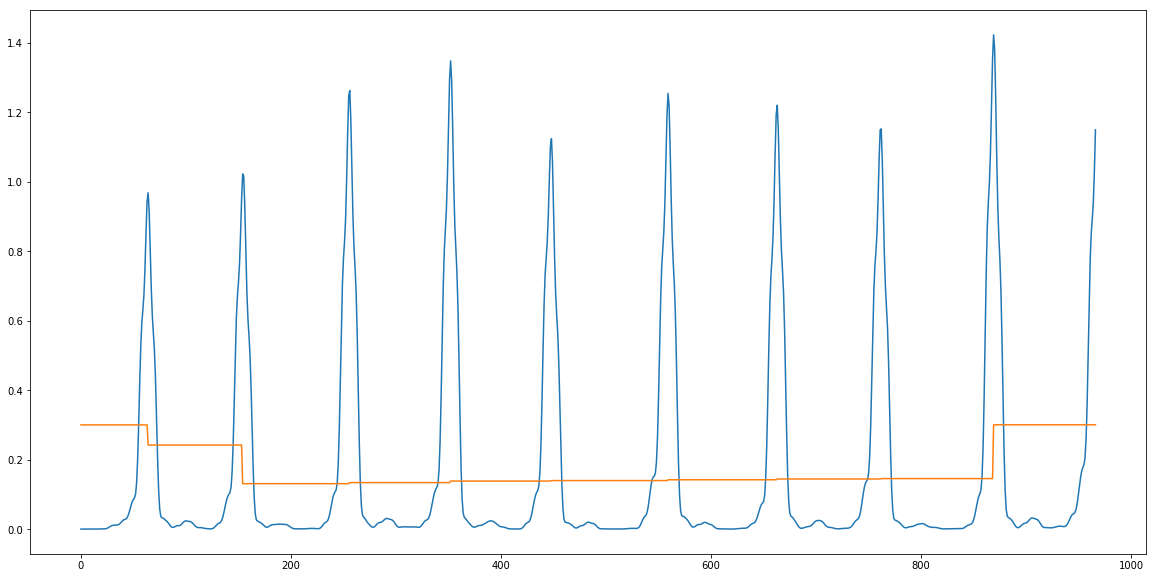

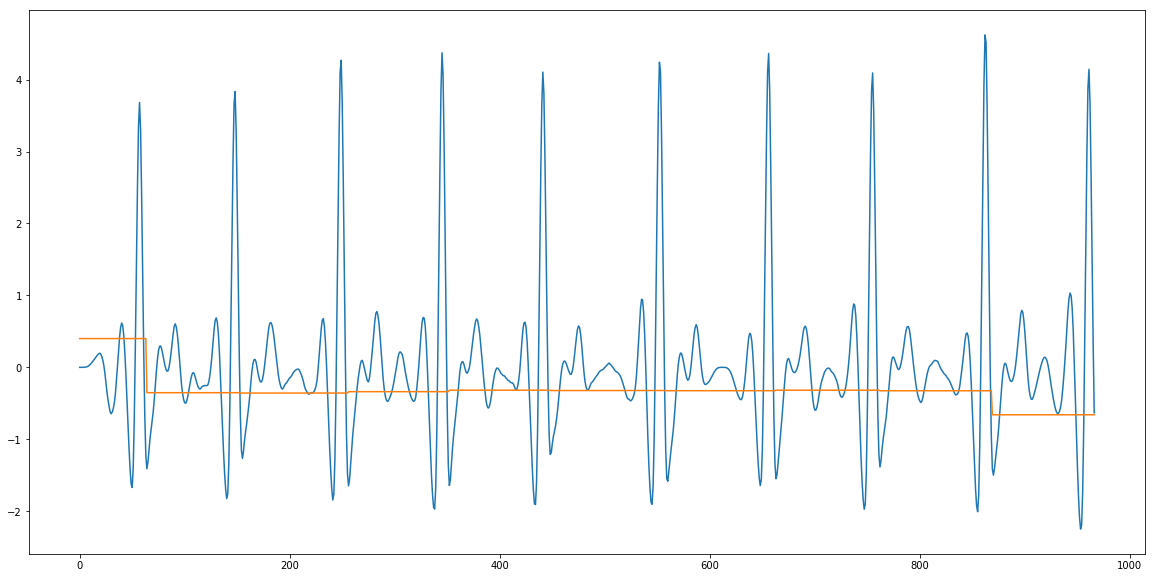

In [196]:
fig, ax_left = plt.subplots(figsize=(20, 10))
ax_right = ax_left.twinx()
ax_left.plot(orig_x, orig_y, label='Original signal')
ax_left.plot(qrs_x, qrs_y, 'ro', label='Rpeak')
ax_right.plot(hrs_x, hrs_y, label='Heart rate', color='m')

ax_left.set_title('QRS detector & Heart rate')

ax_left.set_xlabel('Time (ms)')
ax_left.set_ylabel('ECG V (mV)', color='b')
ax_right.set_ylabel('Heart rate (bpm)', color='m')
# Make the y-axis label, ticks and tick labels match the line color.
ax_left.tick_params('y', colors='b')
ax_right.tick_params('y', colors='m')
# plt.savefig("test.png", dpi=600)
# ax_left.set_xlim(2000, 11000)
plt.show()

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot()
ax.plot(pi)
ax.plot(ti)
# ax.set_xlim(9000, 11000)
plt.show()
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot()
ax.plot(pf)
ax.plot(tf)
# ax.set_xlim(9000, 11000)
plt.show()

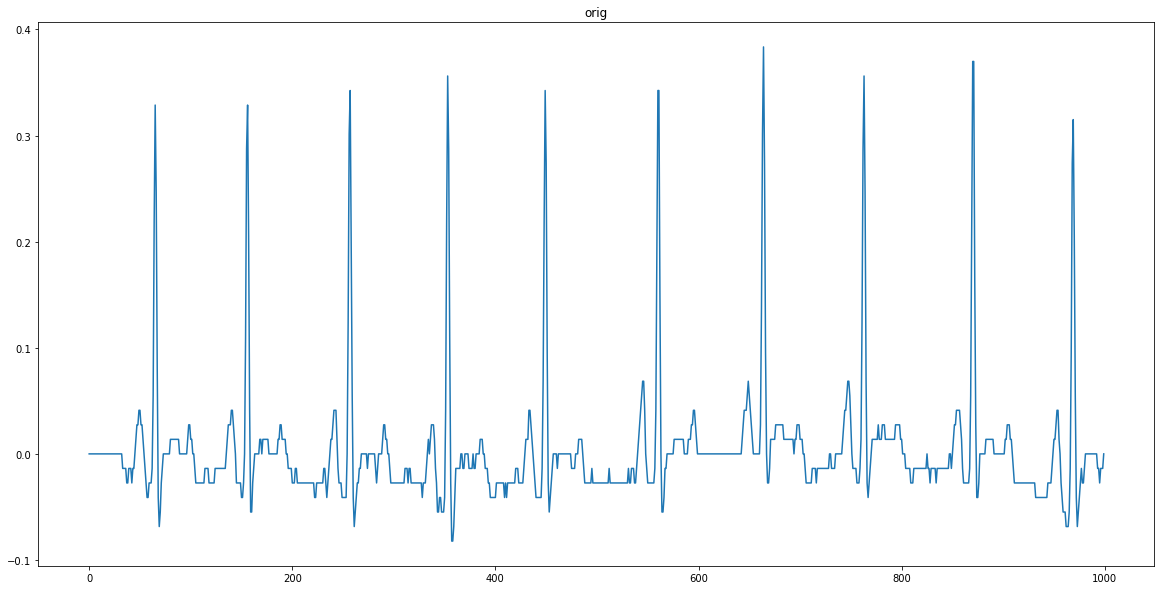

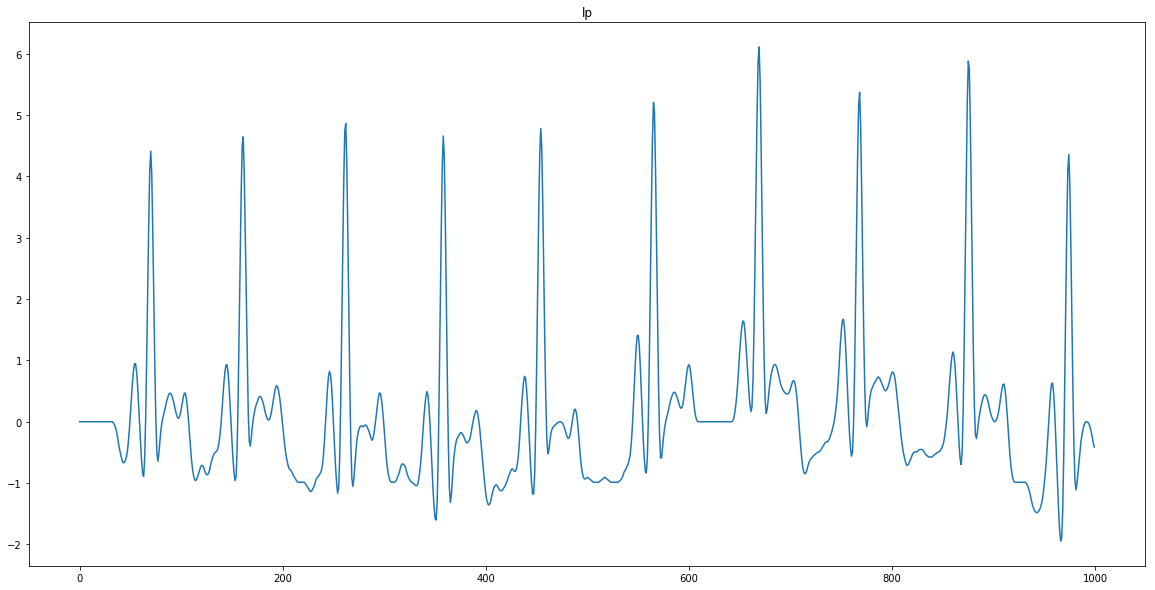

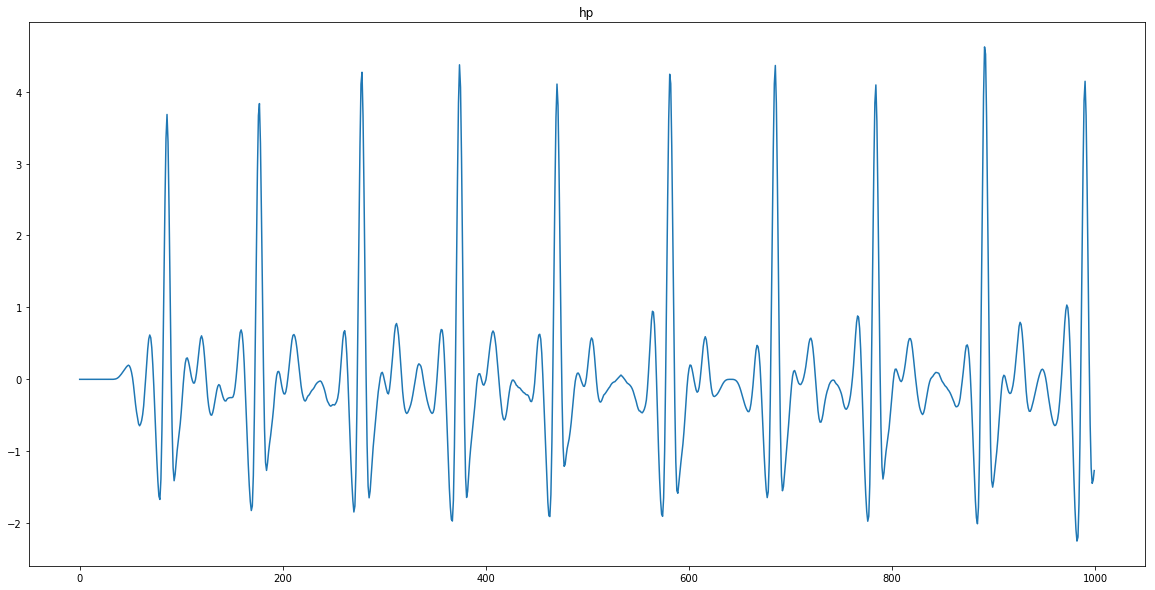

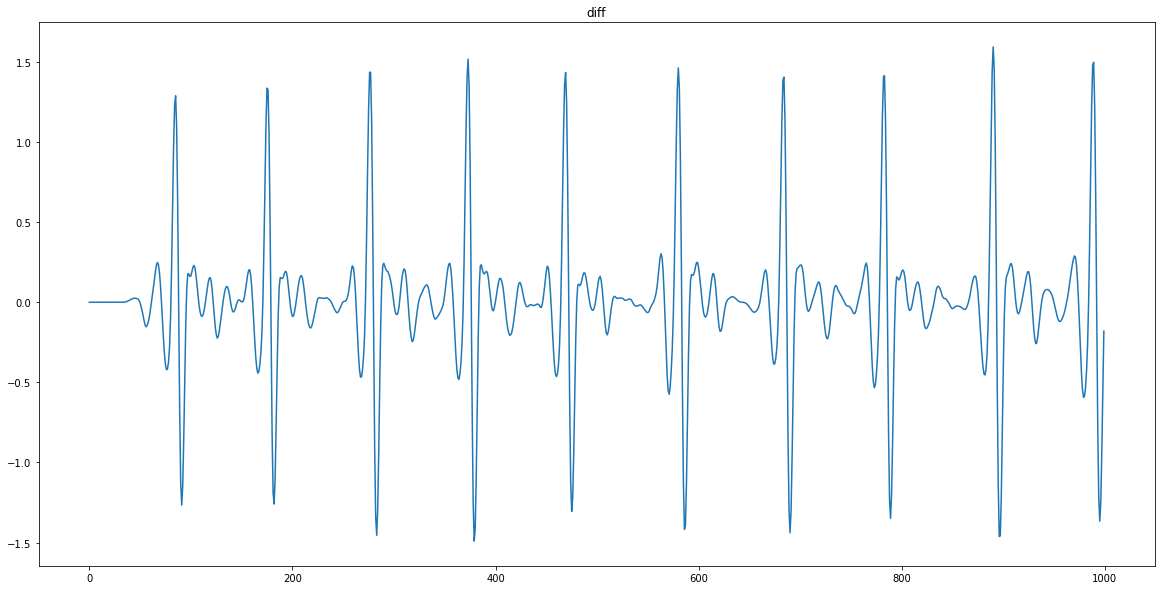

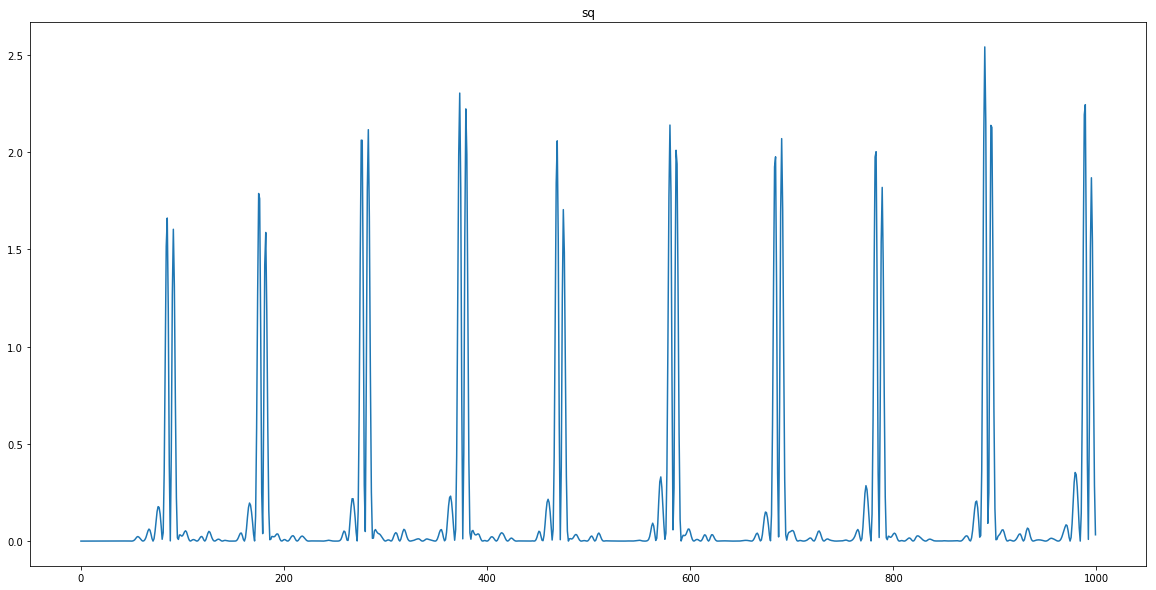

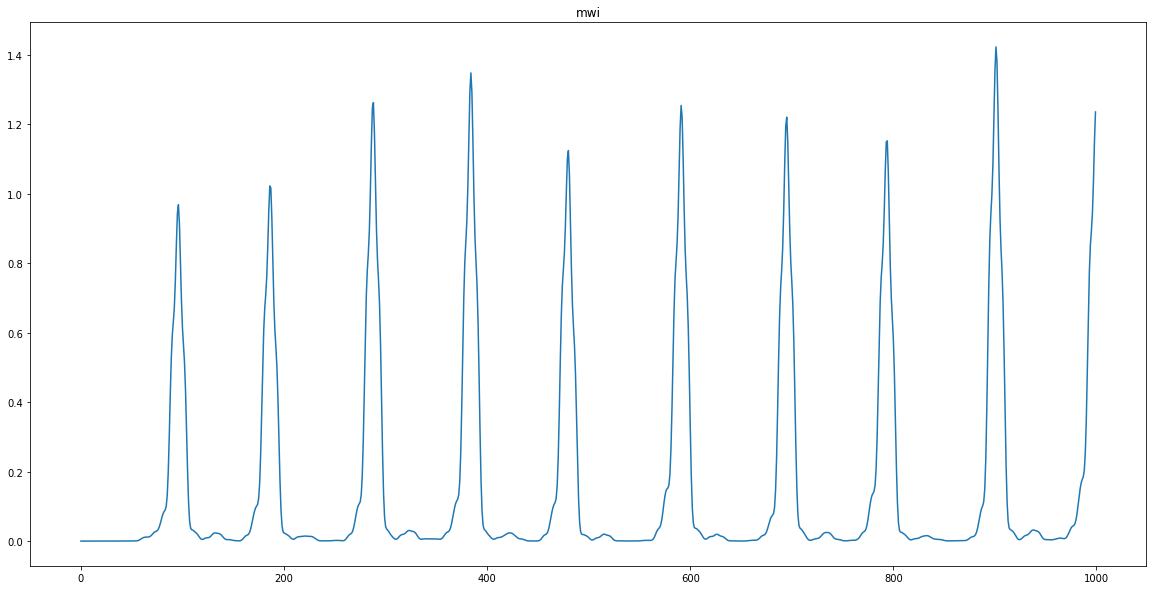

In [189]:
# Plot intermediate values
for k, v in qrs.listeners.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(v.get_all())
    plt.title(k)
    plt.show()

Index for signame II is 0. It contains 885000 samples.
MWI size: 10
prev_peaks_aver = 0.0370061152706
It is a valid Rpeak: v0=0.1761015886481069 >= THRESH1=0.05
prev_peaks_aver = 0.0802950866169


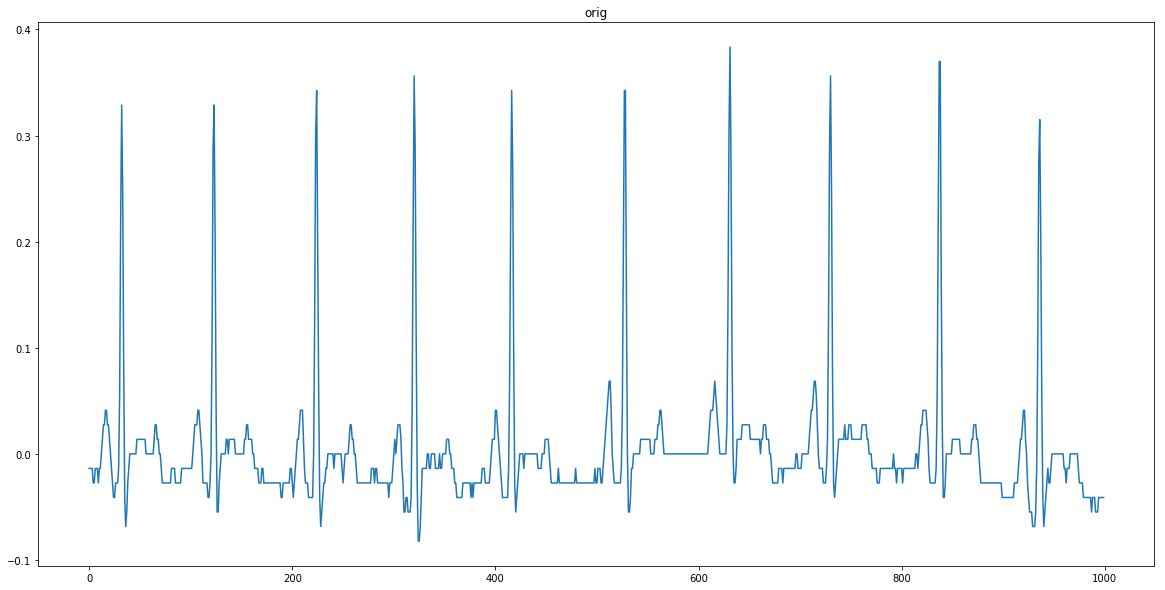

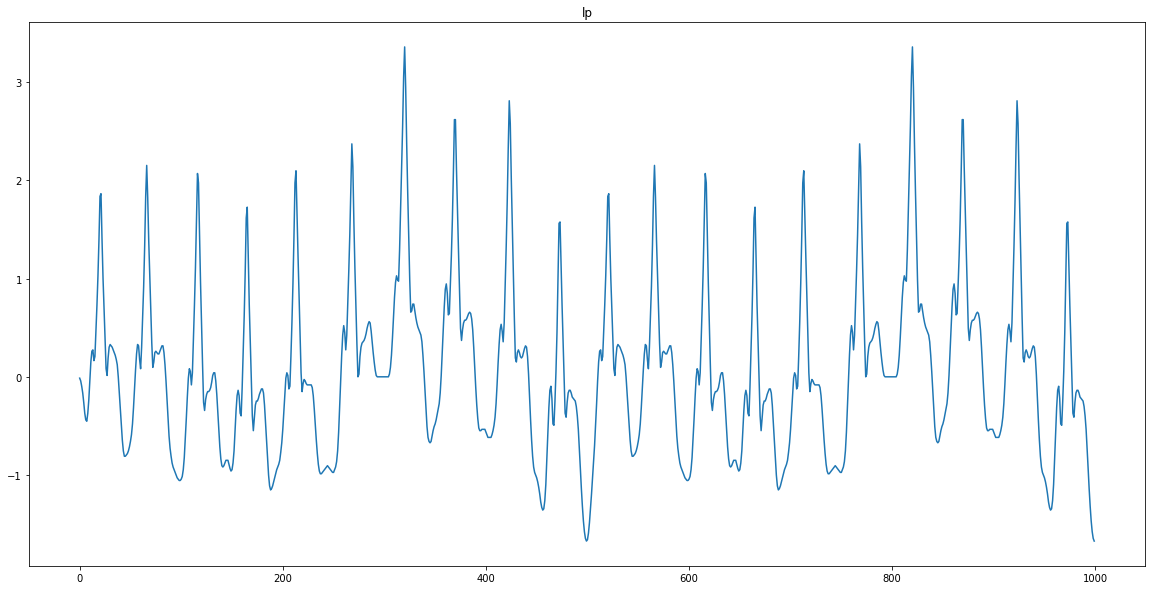

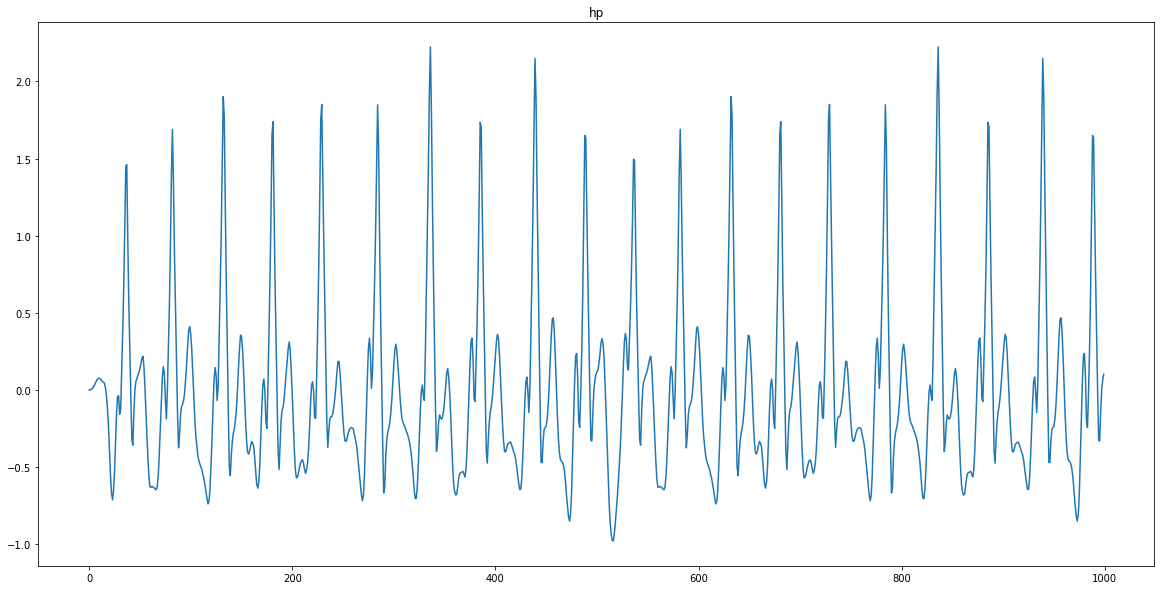

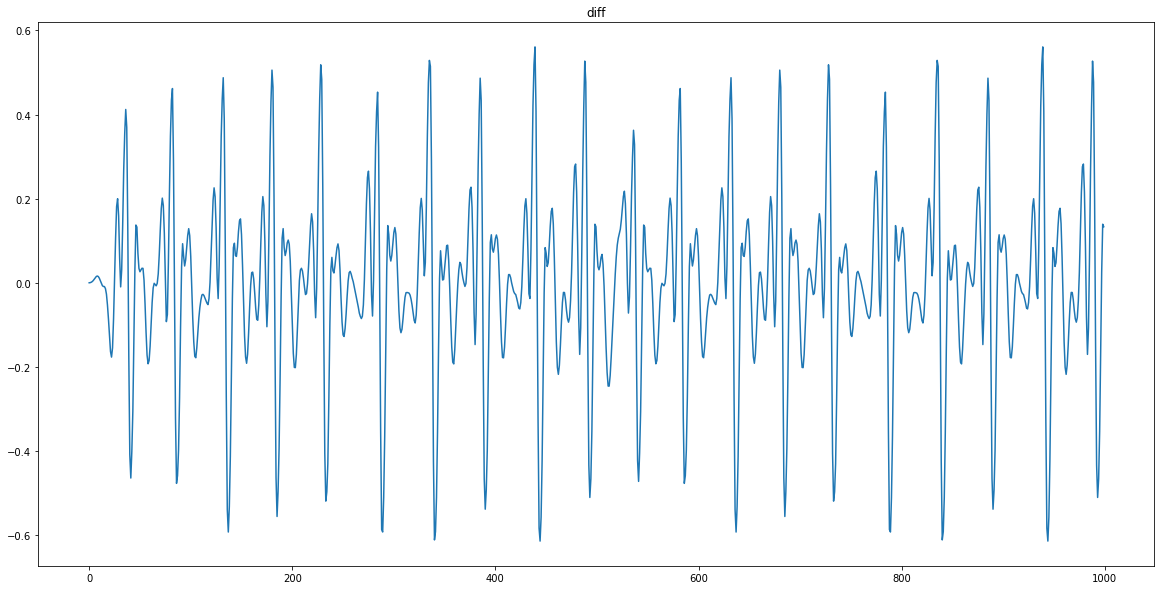

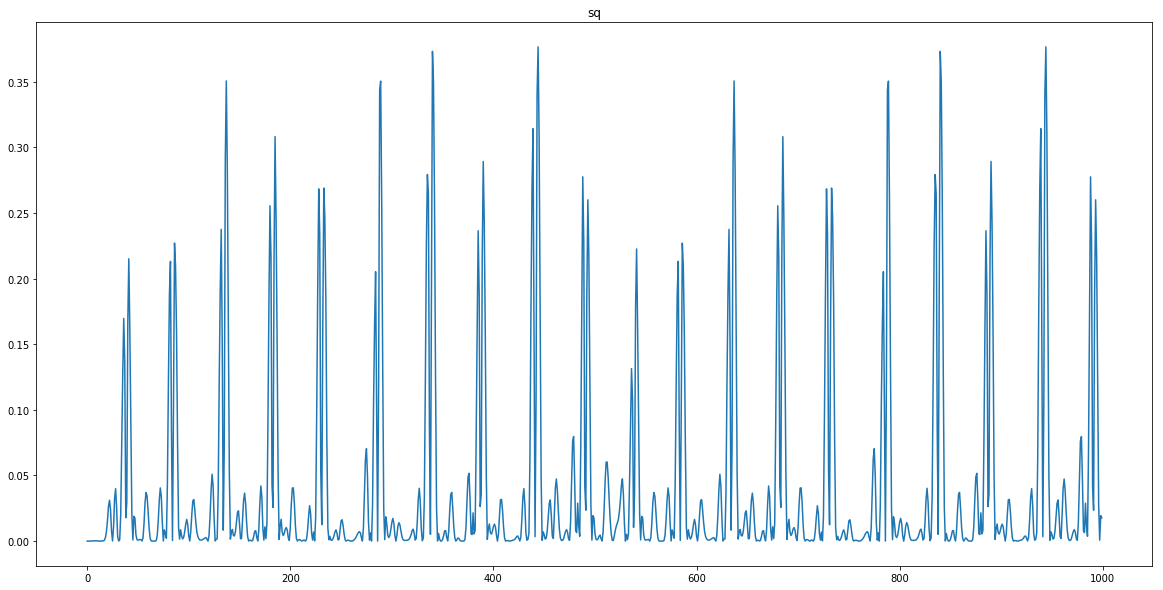

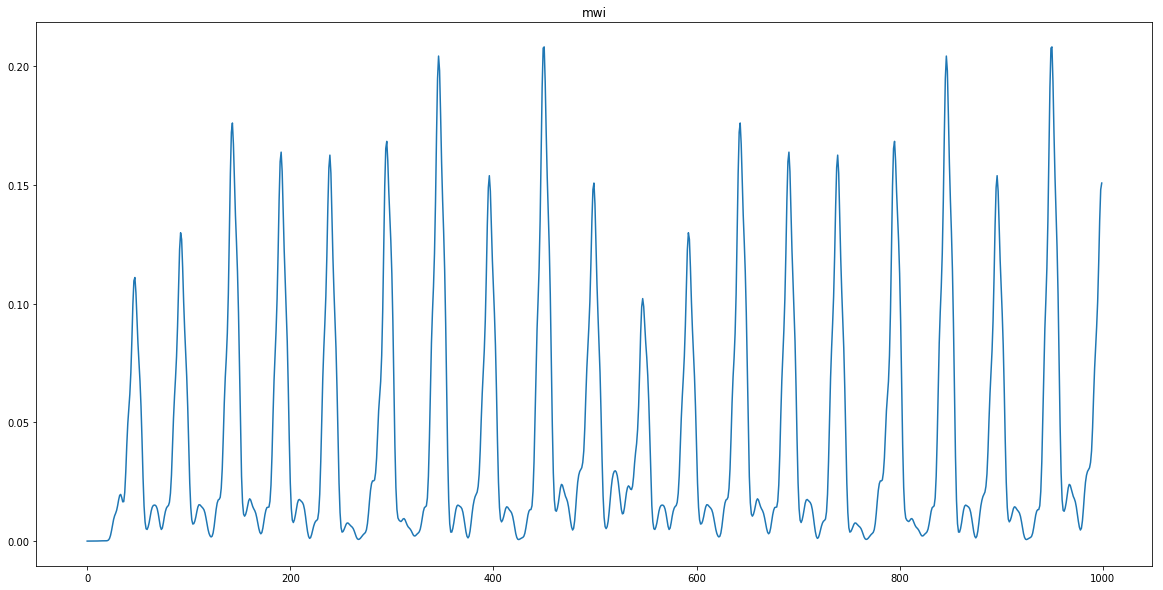

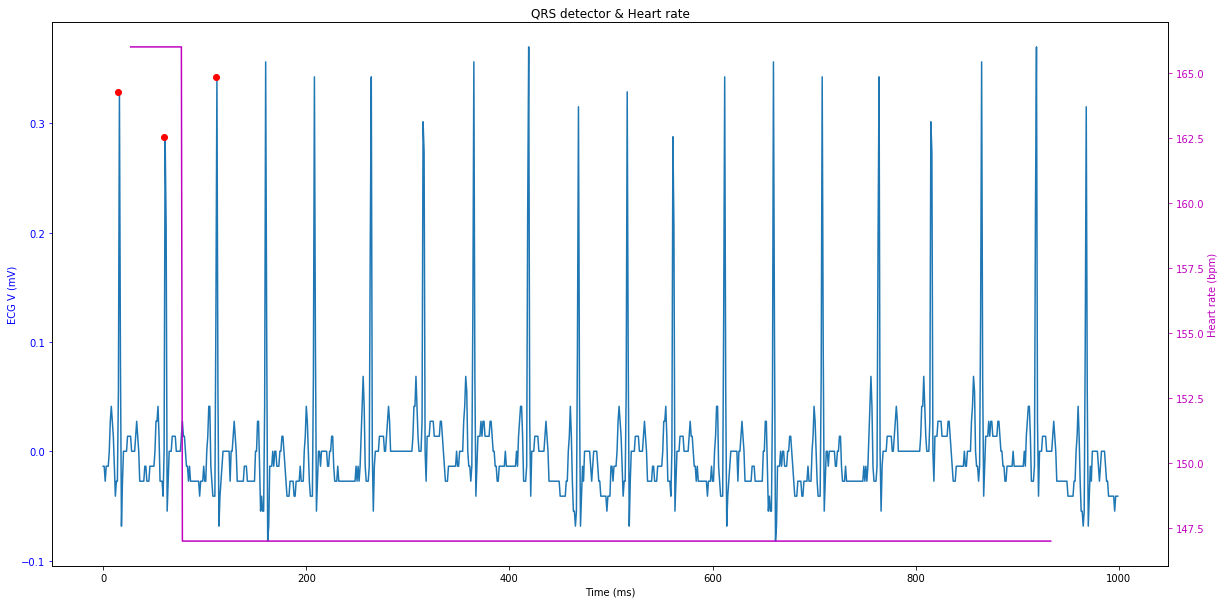

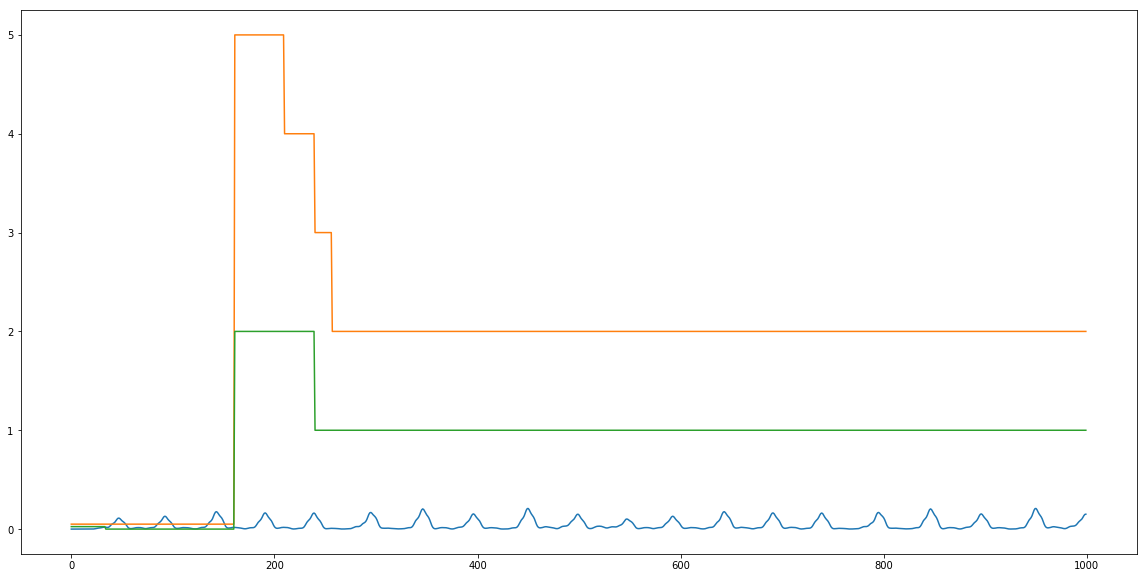

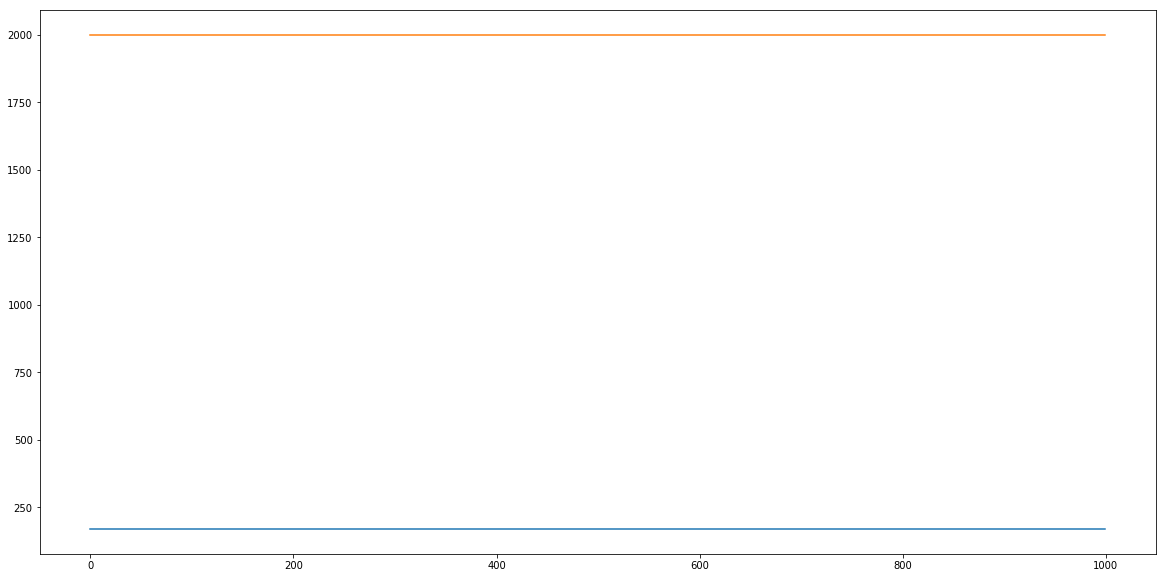

In [16]:
sig_name = "II"
idx_sig = fields['signame'].index(sig_name)

print('Index for signame {} is {}. It contains {} samples.'.format(sig_name, idx_sig, sig.shape[0]))
size = 1000 # sig.shape[0]
fs = fields['fs']

sig1 = sig[None:None, idx_sig]

listeners = {
    'orig': CircularBuffer(size),
    'lp': CircularBuffer(size),
    'hp': CircularBuffer(size),
    'diff': CircularBuffer(size),
    'sq': CircularBuffer(size),
    'mwi': CircularBuffer(size)
}

# data_gen = (RepeatPattern(sig1[:size])-0.5)/2.0
data_gen = RepeatPattern(sig1[:size])
data_gen.add_listener(listeners['orig'])

# Band-pass filter
low_pass = DifferenceEquation(data_gen, "2*y(t-1) - y(t-2) + x(t) - 2*x(t-6) + x(t-12)")
high_pass = DifferenceEquation(low_pass, "y(t-1) - x(t)/32 + x(t-16) - x(t-17) + x(t-32)/32")
low_pass.delay = 5
high_pass.delay = 16
low_pass.add_listener(listeners['lp'])
high_pass.add_listener(listeners['hp'])

# Derivation
diff_gen = DifferenceEquation(high_pass, "(2*x(t) + x(t-1) - x(t-3) - 2*x(t-4))/8.0")
diff_gen.add_listener(listeners['diff'])

# Squaring
sq_gen = diff_gen ** 2
sq_gen.add_listener(listeners['sq'])

# Moving Window Integration
mwi_width = 80 #ms
mwi_size = int((mwi_width/1000)*fs)
print('MWI size: {}'.format(mwi_size))
mwi_gen = MeanHistory(MeanHistory(sq_gen, mwi_size), 4) # Add a MeanHistory(4) to remove noise
mwi_gen.add_listener(listeners['mwi'])

# QRS detector
qrs_gen = QRS(mwi_gen, fs)


# Plot result with multi-y-axes
x_sig = range(size)
y_sig = []
x_rpeak = []
y_rpeak = []
x_hr = []
y_hr = []

t1s = []
t2s = []
rls = []
rhs = []

for k in range(size):
    v = data_gen.get_single()
    d, hr, t1, t2, rl, rh = qrs_gen.get_single()
    t1s.append(t1)
    t2s.append(t2)
    rls.append(rl)
    rhs.append(rh)
    y_sig.append(v)
    if not numpy.isnan(hr):
        x_hr.append(k-33)
        y_hr.append(int(hr))
    if d == 1:
        y_rpeak.append(y_sig[-33])
        x_rpeak.append(k-33)


# Plot intermediate values
for k, v in listeners.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(v.get_all())
    plt.title(k)
    plt.show()
    

        
        
fig, ax_left = plt.subplots(figsize=(20, 10))
ax_right = ax_left.twinx()
ax_left.plot(x_sig, y_sig, label='Original signal')
ax_left.plot(x_rpeak, y_rpeak, 'ro', label='Rpeak')
ax_right.plot(x_hr, y_hr, label='Heart rate', color='m')

ax_left.set_title('QRS detector & Heart rate')

ax_left.set_xlabel('Time (ms)')
ax_left.set_ylabel('ECG V (mV)', color='b')
ax_right.set_ylabel('Heart rate (bpm)', color='m')
# Make the y-axis label, ticks and tick labels match the line color.
ax_left.tick_params('y', colors='b')
ax_right.tick_params('y', colors='m')
plt.show()

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(listeners['mwi'].get_all())
ax.plot(t1s)
ax.plot(t2s)
plt.show()

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(rls)
ax.plot(rhs)
plt.show()